In [ ]:
# =======================================#
# ЯЧЕЙКА 1: ИМПОРТ БИБЛИОТЕК И НАСТРОЙКИ #
# =======================================#

In [ ]:
import pandas as pd
import numpy as np
import os
import csv
import json
import requests
import pytz
from datetime import datetime, timedelta
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# ========== ОСНОВНЫЕ КОНСТАНТЫ ==========
# 1. Часовой пояс (измените на свой)
LOCAL_TIMEZONE = "Europe/Moscow"
local_tz = pytz.timezone(LOCAL_TIMEZONE)

# 2. Файлы данных
CSV_FILENAME = "wellness_diary.csv"
SETTINGS_FILE = "user_settings.json"

# 3. Настройки API
OPENMETEO_URL = "https://api.open-meteo.com/v1/forecast"
GEOCODING_URL = "https://geocoding-api.open-meteo.com/v1/search"

# 4. Опции самочувствия
WELLNESS_OPTIONS = {
    1: "Хорошее",
    2: "Немного уставшее",
    3: "Напрягающая боль",
    4: "Головокружение",
    5: "Средняя головная боль",
    6: "Средняя головная боль и головокружение",
    7: "Сильная головная боль",
    8: "Сильная головная боль и головокружение"
}

# ========== ФУНКЦИИ ПЕРВИЧНОЙ НАСТРОЙКИ ==========

def get_coordinates(city_name):
    """Получает координаты города"""
    params = {"name": city_name, "count": 1, "language": "ru", "format": "json"}

    try:
        response = requests.get(GEOCODING_URL, params=params, timeout=10)
        data = response.json()

        if "results" in data and data["results"]:
            result = data["results"][0]
            return {
                "latitude": result["latitude"],
                "longitude": result["longitude"],
                "city": result["name"],
                "country": result.get("country", ""),
                "admin1": result.get("admin1", "")
            }
        else:
            return None
    except Exception as e:
        print(f"⚠️ Ошибка геокодирования: {e}")
        return None

def first_time_setup():
    """Первичная настройка при первом запуске программы"""
    print("\n" + "="*60)
    print("🌟 ДОБРО ПОЖАЛОВАТЬ В ДНЕВНИК САМОЧУВСТВИЯ!")
    print("="*60)
    print("Пройдите быструю настройку для персонализации приложения.")
    print("="*60)

    # 1. Запрос имени пользователя
    print("\n👤 ШАГ 1: ВАШЕ ИМЯ")
    print("-" * 30)

    while True:
        user_name = input("Как к вам обращаться? (например, 'Алексей'): ").strip()
        if user_name:
            print(f"✅ Привет, {user_name}!")
            break
        else:
            print("❌ Имя не может быть пустым. Попробуйте снова.")

    # 2. Запрос города
    print("\n📍 ШАГ 2: ВАШ ГОРОД")
    print("-" * 30)
    print("Введите название города для отслеживания погоды.")
    print("Пример: 'Москва', 'Санкт-Петербург', 'Новосибирск'")

    city_set = False
    while not city_set:
        city_name = input("\nВведите ваш город (на англ. языке): ").strip()

        if not city_name:
            print("❌ Название города не может быть пустым.")
            continue

        print(f"🔍 Ищу город '{city_name}'...")
        location = get_coordinates(city_name)

        if location:
            print(f"✅ Город найден: {location['city']}")

            if location.get('country'):
                print(f"   Страна: {location['country']}")
            if location.get('admin1'):
                print(f"   Регион: {location['admin1']}")
            print(f"   Координаты: {location['latitude']:.4f}, {location['longitude']:.4f}")

            confirm = input("\nЭто правильный город? (да/нет): ").strip().lower()
            if confirm in ['да', 'д', 'yes', 'y', '']:
                city_set = True
                city_data = location
            else:
                print("Попробуйте ввести город по-другому.")
        else:
            print(f"❌ Город '{city_name}' не найден.")
            retry = input("Попробовать снова? (да/нет): ").strip().lower()
            if retry not in ['да', 'д', 'yes', 'y', '']:
                # Используем город по умолчанию
                print("⚠️ Используем город по умолчанию: Москва")
                city_data = {
                    "city": "Москва",
                    "latitude": 55.7558,
                    "longitude": 37.6173,
                    "country": "Россия"
                }
                city_set = True

    # 3. Создание настроек
    settings = {
        "user_name": user_name,
        "city": city_data["city"],
        "latitude": city_data["latitude"],
        "longitude": city_data["longitude"],
        "country": city_data.get("country", ""),
        "timezone": LOCAL_TIMEZONE,
        "first_setup_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "version": "2.0"
    }

    # 4. Сохранение настроек
    try:
        with open(SETTINGS_FILE, 'w', encoding='utf-8') as f:
            json.dump(settings, f, ensure_ascii=False, indent=2)

        print("\n" + "="*60)
        print("✅ НАСТРОЙКА ЗАВЕРШЕНА!")
        print("="*60)
        print(f"👤 Имя: {user_name}")
        print(f"📍 Город: {city_data['city']}")
        if city_data.get('country'):
            print(f"🌍 Страна: {city_data['country']}")
        print(f"⏰ Часовой пояс: {LOCAL_TIMEZONE}")
        print("="*60)
        print("Настройки сохранены. Теперь вы можете использовать дневник!")

        return settings
    except Exception as e:
        print(f"❌ Ошибка сохранения настроек: {e}")
        # Возвращаем настройки по умолчанию
        return {
            "user_name": "Пользователь",
            "city": "Москва",
            "latitude": 55.7558,
            "longitude": 37.6173,
            "timezone": LOCAL_TIMEZONE
        }

def load_settings():
    """Загружает настройки пользователя или запускает первичную настройку"""
    if os.path.exists(SETTINGS_FILE):
        try:
            with open(SETTINGS_FILE, 'r', encoding='utf-8') as f:
                settings = json.load(f)

            # Проверяем, что все обязательные поля есть
            required_fields = ["user_name", "city", "latitude", "longitude"]
            for field in required_fields:
                if field not in settings:
                    print(f"⚠️ В настройках отсутствует поле {field}. Запускаю первичную настройку...")
                    return first_time_setup()

            print(f"✅ Настройки загружены. Добро пожаловать, {settings['user_name']}!")
            return settings
        except Exception as e:
            print(f"⚠️ Ошибка загрузки настроек: {e}")
            print("Запускаю первичную настройку...")
            return first_time_setup()
    else:
        print("🆕 Первый запуск программы. Запускаю первичную настройку...")
        return first_time_setup()

# ========== ЗАГРУЗКА НАСТРОЕК ==========

print("🔄 Загрузка программы...")
USER_SETTINGS = load_settings()

print("\n" + "="*60)
print("✅ ПРОГРАММА ГОТОВА К РАБОТЕ")
print("="*60)
print(f"👤 Пользователь: {USER_SETTINGS['user_name']}")
print(f"📍 Город: {USER_SETTINGS['city']}")
print(f"⏰ Часовой пояс: {LOCAL_TIMEZONE}")
print("="*60)

🔄 Загрузка программы...
🆕 Первый запуск программы. Запускаю первичную настройку...

🌟 ДОБРО ПОЖАЛОВАТЬ В ДНЕВНИК САМОЧУВСТВИЯ!
Пройдите быструю настройку для персонализации приложения.

👤 ШАГ 1: ВАШЕ ИМЯ
------------------------------
Как к вам обращаться? (например, 'Алексей'): Денис
✅ Привет, Денис!

📍 ШАГ 2: ВАШ ГОРОД
------------------------------
Введите название города для отслеживания погоды.
Пример: 'Москва', 'Санкт-Петербург', 'Новосибирск'

Введите ваш город: Apatity
🔍 Ищу город 'Apatity'...
✅ Город найден: Апатиты
   Страна: Россия
   Регион: Мурманская Область
   Координаты: 67.5827, 33.4134

Это правильный город? (да/нет): да

✅ НАСТРОЙКА ЗАВЕРШЕНА!
👤 Имя: Денис
📍 Город: Апатиты
🌍 Страна: Россия
⏰ Часовой пояс: Europe/Moscow
Настройки сохранены. Теперь вы можете использовать дневник!

✅ ПРОГРАММА ГОТОВА К РАБОТЕ
👤 Пользователь: Денис
📍 Город: Апатиты
⏰ Часовой пояс: Europe/Moscow


In [ ]:
# =================================================#
# ЯЧЕЙКА 2: ФУНКЦИИ ДЛЯ РАБОТЫ С ПОГОДОЙ И ДАННЫМИ #
# =================================================#

In [ ]:
# ----- 1. Функции геокодирования и настроек -----
def update_city_settings(city_name):
    """Обновляет настройки города и координаты"""
    location = get_coordinates(city_name)

    if location:
        USER_SETTINGS.update({
            "city": location["city"],
            "latitude": location["latitude"],
            "longitude": location["longitude"],
            "country": location.get("country", "")
        })

        # Сохраняем настройки
        save_settings()

        print(f"✅ Город обновлён: {location['city']}")
        if location.get('country'):
            print(f"🌍 Страна: {location['country']}")
        print(f"📌 Координаты: {location['latitude']:.4f}, {location['longitude']:.4f}")

        if location.get('admin1'):
            print(f"📍 Регион: {location['admin1']}")

        return True
    else:
        print(f"❌ Город '{city_name}' не найден")
        return False

def save_settings():
    """Сохраняет настройки в файл"""
    try:
        with open(SETTINGS_FILE, 'w', encoding='utf-8') as f:
            json.dump(USER_SETTINGS, f, ensure_ascii=False, indent=2)
        return True
    except Exception as e:
        print(f"❌ Ошибка сохранения настроек: {e}")
        return False

# ----- 2. Функции получения погоды -----
def get_weather_data(latitude, longitude, date_str=None, time_str=None):
    """Получает погодные данные для указанных координат, даты и времени"""
    # 1. Определяем переменную hour
    hour = 12  # Значение по умолчанию (полдень)

    if time_str:
        try:
            hour = int(time_str.split(':')[0])
        except:
            hour = 12

    # 2. Базовые параметры запроса
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "hourly": "temperature_2m,relative_humidity_2m,windspeed_10m,pressure_msl,weathercode",
        "timezone": "auto",
        "windspeed_unit": "ms"
    }

    # 3. Логика выбора параметров даты
    if date_str:
        params["start_date"] = date_str
        params["end_date"] = date_str
    else:
        params["forecast_days"] = 1

    try:
        response = requests.get(OPENMETEO_URL, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()

        hourly_data = data.get("hourly", {})
        if hourly_data and len(hourly_data.get("time", [])) > 0:
            # 4. Используем переменную hour для поиска нужного индекса
            times = hourly_data.get("time", [])
            target_index = min(hour, len(times) - 1)

            weather_data = {
                'temperature': hourly_data.get("temperature_2m", [])[target_index] if hourly_data.get("temperature_2m") else None,
                'humidity': hourly_data.get("relative_humidity_2m", [])[target_index] if hourly_data.get("relative_humidity_2m") else None,
                'wind_speed': hourly_data.get("windspeed_10m", [])[target_index] if hourly_data.get("windspeed_10m") else None,
                'pressure': hourly_data.get("pressure_msl", [])[target_index] if hourly_data.get("pressure_msl") else None,
                'weather_code': hourly_data.get("weathercode", [])[target_index] if hourly_data.get("weathercode") else None
            }

            weather_data['weather_description'] = interpret_weathercode(weather_data['weather_code'])

            return weather_data
        else:
            print("⚠️ API не вернуло почасовых данных")
            return None

    except requests.exceptions.Timeout:
        print("❌ Таймаут запроса к API погоды")
        return None
    except requests.exceptions.RequestException as e:
        print(f"❌ Ошибка сети: {e}")
        return None
    except Exception as e:
        print(f"⚠️ Неожиданная ошибка: {e}")
        return None

def get_weather_forecast(days=3):
    """Получает прогноз погоды на указанное количество дней"""
    print(f"\n🌤️ ЗАПРАШИВАЮ ПРОГНОЗ ПОГОДЫ НА {days} ДНЯ...")
    print(f"📍 Для города: {USER_SETTINGS['city']}")

    params = {
        "latitude": USER_SETTINGS["latitude"],
        "longitude": USER_SETTINGS["longitude"],
        "daily": "weathercode,temperature_2m_max,temperature_2m_min,pressure_msl_max,pressure_msl_min,relative_humidity_2m_max,relative_humidity_2m_min",
        "timezone": "auto",
        "forecast_days": days
    }

    try:
        response = requests.get(OPENMETEO_URL, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()

        daily_data = data.get("daily", {})

        if daily_data and len(daily_data.get("time", [])) > 0:
            print("\n" + "="*60)
            print(f"📅 ПРОГНОЗ ПОГОДЫ НА {days} ДНЯ")
            print(f"📍 {USER_SETTINGS['city']}")
            print("="*60)

            for i in range(min(days, len(daily_data["time"]))):
                date = daily_data["time"][i]
                weather_code = daily_data.get("weathercode", [])[i]
                weather_desc = interpret_weathercode(weather_code)

                temp_max = daily_data.get("temperature_2m_max", [])[i]
                temp_min = daily_data.get("temperature_2m_min", [])[i]

                pressure_max = daily_data.get("pressure_msl_max", [])[i]
                pressure_min = daily_data.get("pressure_msl_min", [])[i]

                humidity_max = daily_data.get("relative_humidity_2m_max", [])[i]
                humidity_min = daily_data.get("relative_humidity_2m_min", [])[i]

                print(f"\n📅 {date}:")
                print(f"   {get_weather_icon(weather_code)} {weather_desc}")
                print(f"   🌡 Температура: {temp_min:.1f}°C ... {temp_max:.1f}°C")
                print(f"   🎯 Давление: {pressure_min:.0f} ... {pressure_max:.0f} гПа")
                print(f"   💧 Влажность: {humidity_min:.0f}% ... {humidity_max:.0f}%")

                # Добавляем рекомендации на основе погоды
                recommendation = get_weather_recommendation(weather_code, temp_max, pressure_min)
                if recommendation:
                    print(f"   💡 Рекомендация: {recommendation}")

            print("\n" + "="*60)
            print("📊 ОБЩАЯ СВОДКА:")

            # Анализируем прогноз
            avg_temp = sum(daily_data.get("temperature_2m_max", [])[:days]) / days
            avg_pressure = sum(daily_data.get("pressure_msl_max", [])[:days]) / days

            print(f"   • Средняя температура: {avg_temp:.1f}°C")
            print(f"   • Среднее давление: {avg_pressure:.0f} гПа")

            # Проверяем на резкие изменения
            if days > 1:
                pressure_changes = []
                for j in range(1, days):
                    change = daily_data.get("pressure_msl_max", [])[j] - daily_data.get("pressure_msl_max", [])[j-1]
                    pressure_changes.append(abs(change))

                max_change = max(pressure_changes) if pressure_changes else 0
                if max_change > 10:
                    print(f"   ⚠️ Ожидаются резкие перепады давления (до {max_change:.0f} гПа)")

            print("="*60)

            return daily_data
        else:
            print("❌ API не вернуло данных прогноза")
            return None

    except requests.exceptions.Timeout:
        print("❌ Таймаут запроса к API погоды")
        return None
    except requests.exceptions.RequestException as e:
        print(f"❌ Ошибка сети: {e}")
        return None
    except Exception as e:
        print(f"⚠️ Неожиданная ошибка: {e}")
        return None

def interpret_weathercode(code):
    """Расшифровка кодов погоды WMO"""
    if code is None:
        return "Нет данных"

    codes = {
        0: "Ясно, солнечно", 1: "Преимущественно ясно", 2: "Переменная облачность",
        3: "Пасмурно", 45: "Туман", 48: "Инейный туман",
        51: "Лёгкая морось", 53: "Умеренная морось", 55: "Сильная морось",
        61: "Небольшой дождь", 63: "Умеренный дождь", 65: "Сильный дождь",
        71: "Небольшой снег", 73: "Умеренный снег", 75: "Сильный снег",
        80: "Ливень", 81: "Сильный ливень", 82: "Очень сильный ливень",
        95: "Гроза", 96: "Гроза с небольшим градом", 99: "Гроза с сильным градом"
    }

    return codes.get(code, f"Код погоды: {code}")

def get_weather_icon(code):
    """Возвращает эмодзи для типа погоды"""
    icons = {
        0: "☀️", 1: "🌤", 2: "⛅", 3: "☁️",
        45: "🌫", 48: "🌫",
        51: "🌦", 53: "🌦", 55: "🌧",
        61: "🌧", 63: "🌧", 65: "🌧",
        71: "🌨", 73: "🌨", 75: "🌨",
        80: "⛈", 81: "⛈", 82: "⛈",
        95: "⛈", 96: "⛈🌨", 99: "⛈🌨"
    }
    return icons.get(code, "🌡")

def get_weather_recommendation(code, temp, pressure):
    """Генерирует рекомендации на основе погоды"""
    recommendations = []

    # По температуре
    if temp > 30:
        recommendations.append("Избегайте длительного пребывания на солнце")
    elif temp < -10:
        recommendations.append("Одевайтесь теплее, избегайте переохлаждения")

    # По типу погоды
    if code in [61, 63, 65, 80, 81, 82, 95, 96, 99]:
        recommendations.append("Возьмите зонт или дождевик")
    elif code in [71, 73, 75]:
        recommendations.append("Будьте осторожны на улицах, возможен гололёд")
    elif code in [45, 48]:
        recommendations.append("Будьте осторожны на дорогах, ограниченная видимость")

    # По давлению (условные значения)
    if pressure < 980:
        recommendations.append("Низкое давление - возможны головные боли у метеозависимых")
    elif pressure > 1020:
        recommendations.append("Высокое давление - следите за самочувствием")

    if recommendations:
        return "; ".join(recommendations[:2])  # Не более 2 рекомендаций
    return None

# ----- 3. Вспомогательные функции -----
def input_datetime():
    """Ввод даты и времени с правильным часовым поясом"""
    print(f"\n📅 ВВОД ДАТЫ И ВРЕМЕНИ ({LOCAL_TIMEZONE}):")
    print("1. Текущее время")
    print("2. Конкретная дата и время")
    print("3. Только дата (время 12:00)")

    choice = input("Выберите (1-3): ").strip()

    if choice == "1":
        now = datetime.now(local_tz)
        date_str = now.strftime("%Y-%m-%d")
        time_str = now.strftime("%H:%M")
        print(f"✅ Текущее время: {date_str} {time_str}")

    elif choice == "2":
        while True:
            date_input = input("Дата (ГГГГ-ММ-ДД): ").strip()
            time_input = input("Время (ЧЧ:ММ): ").strip()

            try:
                dt = datetime.strptime(f"{date_input} {time_input}", "%Y-%m-%d %H:%M")
                local_dt = local_tz.localize(dt)
                date_str = local_dt.strftime("%Y-%m-%d")
                time_str = local_dt.strftime("%H:%M")
                break
            except ValueError:
                print("❌ Неверный формат. Пример: 2024-01-15 14:30")

    elif choice == "3":
        while True:
            date_input = input("Дата (ГГГГ-ММ-ДД): ").strip()
            try:
                dt = datetime.strptime(date_input, "%Y-%m-%d")
                local_dt = local_tz.localize(dt.replace(hour=12, minute=0))
                date_str = local_dt.strftime("%Y-%m-%d")
                time_str = local_dt.strftime("%H:%M")
                break
            except ValueError:
                print("❌ Неверный формат. Пример: 2024-01-15")
    else:
        print("⚠️ Неверный выбор. Используется текущее время.")
        now = datetime.now(local_tz)
        date_str = now.strftime("%Y-%m-%d")
        time_str = now.strftime("%H:%M")

    return date_str, time_str

def select_wellness():
    """Выбор самочувствия"""
    print("\n🧠 ВАШЕ САМОЧУВСТВИЕ:")
    for key, value in WELLNESS_OPTIONS.items():
        print(f"{key}. {value}")

    while True:
        try:
            choice = int(input("Введите номер (1-8): "))
            if 1 <= choice <= 8:
                return choice, WELLNESS_OPTIONS[choice]
            else:
                print("❌ Введите число от 1 до 8")
        except ValueError:
            print("❌ Введите число")

def input_manual_weather():
    """Ручной ввод погодных данных"""
    print("\n🌤️ РУЧНОЙ ВВОД ПОГОДЫ:")
    weather = {}

    fields = [
        ("temperature", "Температура (°C)", float),
        ("humidity", "Влажность (%)", float),
        ("wind_speed", "Скорость ветра (м/с)", float),
        ("pressure", "Давление (гПа)", float),
        ("magnetic", "Магнитная активность", str),
        ("solar", "Солнечные вспышки", str)
    ]

    for key, label, dtype in fields:
        value = input(f"{label} (Enter чтобы пропустить): ").strip()
        if value:
            try:
                weather[key] = dtype(value) if dtype != str else value
            except:
                print(f"⚠️ Неверный формат для {label}")

    return weather

print("✅ Функции для работы с погодой загружены")

✅ Функции для работы с погодой загружены


In [ ]:
# ========================================#
# ЯЧЕЙКА 3: ФУНКЦИИ ДНЕВНИКА САМОЧУВСТВИЯ #
# ========================================#

In [ ]:


def initialize_csv():
    """Инициализация CSV файла"""
    if not os.path.exists(CSV_FILENAME):
        headers = [
            "user_name", "date", "time", "wellness_code", "wellness_text",
            "temperature", "humidity", "wind_speed", "pressure",
            "weather_code", "weather_description",
            "magnetic_activity", "solar_flares",
            "weather_source", "notes"
        ]

        with open(CSV_FILENAME, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f, quoting=csv.QUOTE_ALL)
            writer.writerow(headers)

        print(f"✅ Создан файл {CSV_FILENAME}")

def add_record():
    """Добавление новой записи"""
    print("\n" + "="*50)
    print("НОВАЯ ЗАПИСЬ")
    print("="*50)

    # 1. Ввод даты и времени
    date_str, time_str = input_datetime()

    # 2. Выбор самочувствия
    wellness_code, wellness_text = select_wellness()

    # 3. Погодные данные
    weather = {}
    print("\n🌤️ ПОГОДНЫЕ ДАННЫЕ:")
    print("1. Автоматически (Open-Meteo)")
    print("2. Ввести вручную")
    print("3. Пропустить")

    weather_choice = input("Выберите (1-3): ").strip()

    if weather_choice == "1":
        print(f"\n📡 Получаю погоду для {USER_SETTINGS['city']}...")
        auto_weather = get_weather_data(
            USER_SETTINGS["latitude"],
            USER_SETTINGS["longitude"],
            date_str,
            time_str
        )

        if auto_weather:
            weather = auto_weather
            weather['weather_source'] = f"Open-Meteo ({USER_SETTINGS['city']})"
            print("✅ Погода получена")
        else:
            print("❌ Не удалось получить погоду")
            weather = input_manual_weather()
            weather['weather_source'] = "Ручной ввод (после ошибки авто)"

    elif weather_choice == "2":
        weather = input_manual_weather()
        weather['weather_source'] = "Ручной ввод"

    else:
        weather = {'weather_source': 'Не указано'}
        print("⚠️ Погода не будет записана")

    # 4. Дополнительные поля
    if 'magnetic' not in weather:
        weather['magnetic'] = input("Магнитная активность (Enter чтобы пропустить): ").strip()

    if 'solar' not in weather:
        weather['solar'] = input("Солнечные вспышки (Enter чтобы пропустить): ").strip()

    notes = input("\n📝 Заметки (Enter чтобы пропустить): ").strip()

    # 5. Формирование записи
    record = {
        'user_name': USER_SETTINGS['user_name'],
        'date': date_str,
        'time': time_str,
        'wellness_code': wellness_code,
        'wellness_text': wellness_text,
        'temperature': weather.get('temperature', ''),
        'humidity': weather.get('humidity', ''),
        'wind_speed': weather.get('wind_speed', ''),
        'pressure': weather.get('pressure', ''),
        'weather_code': weather.get('weather_code', ''),
        'weather_description': weather.get('weather_description', ''),
        'magnetic_activity': weather.get('magnetic', ''),
        'solar_flares': weather.get('solar', ''),
        'weather_source': weather.get('weather_source', ''),
        'notes': notes
    }

    # 6. Запись в CSV с экранированием кавычками
    file_exists = os.path.isfile(CSV_FILENAME)

    with open(CSV_FILENAME, 'a', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=record.keys(), quoting=csv.QUOTE_ALL)

        if not file_exists:
            writer.writeheader()

        writer.writerow(record)

    print(f"\n✅ Запись добавлена: {date_str} {time_str}")

    # 7. Сводка
    print("\n📋 СВОДКА:")
    print(f"👤 Пользователь: {USER_SETTINGS['user_name']}")
    print(f"📅 Дата/время: {date_str} {time_str}")
    print(f"🧠 Самочувствие: {wellness_text}")

    if weather.get('temperature'):
        print(f"🌡 Температура: {weather['temperature']}°C")
    if weather.get('humidity'):
        print(f"💧 Влажность: {weather['humidity']}%")
    if weather.get('weather_description'):
        print(f"🌤 Погода: {weather['weather_description']}")

    return record

def view_table_paginated(page_size=20):
    """Просмотр записей с пагинацией"""
    if not os.path.exists(CSV_FILENAME):
        print("📭 Нет данных для отображения")
        return

    df = pd.read_csv(CSV_FILENAME)

    if df.empty:
        print("📭 Таблица пуста")
        return

    total_records = len(df)
    total_pages = (total_records + page_size - 1) // page_size
    current_page = 1

    while True:
        print("\n" + "="*80)
        print(f"📖 ПРОСМОТР ЗАПИСЕЙ (Страница {current_page}/{total_pages})")
        print(f"📊 Всего записей: {total_records}")
        print("="*80)

        # Вычисляем индексы для текущей страницы
        start_idx = (current_page - 1) * page_size
        end_idx = min(start_idx + page_size, total_records)

        # Получаем данные для текущей страницы
        page_df = df.iloc[start_idx:end_idx]

        # Определяем колонки для показа
        basic_cols = ['user_name', 'date', 'time', 'wellness_text', 'temperature', 'weather_description']
        available_cols = [col for col in basic_cols if col in page_df.columns]

        if available_cols:
            display_df = page_df[available_cols]
        else:
            display_df = page_df

        # Красивое отображение
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 1000)
        pd.set_option('display.max_colwidth', 20)

        print(display_df.to_string(index=False))

        print(f"\n📄 Записи: {start_idx + 1}-{end_idx} из {total_records}")

        # Навигация
        print("\n🔍 НАВИГАЦИЯ:")
        if current_page > 1:
            print("1. Предыдущая страница")
        if current_page < total_pages:
            print("2. Следующая страница")
        print("3. Обновить текущую страницу")
        print("4. Вернуться в главное меню")

        choice = input("\nВыберите действие: ").strip().upper()

        if choice == '1' and current_page > 1:
            current_page -= 1
        elif choice == '2' and current_page < total_pages:
            current_page += 1
        elif choice == '3':
            continue  # Обновляем текущую страницу
        elif choice == '4':
            print("\nВозвращаюсь в главное меню...")
            break
        else:
            print("❌ Неверный выбор. Попробуйте снова.")

def analyze_data():
    """Анализ данных"""
    if not os.path.exists(CSV_FILENAME):
        print("❌ Нет данных для анализа")
        return

    df = pd.read_csv(CSV_FILENAME)

    print("\n" + "="*50)
    print("📈 АНАЛИЗ ДАННЫХ")
    print("="*50)

    # Фильтруем по текущему пользователю
    user_df = df[df['user_name'] == USER_SETTINGS['user_name']]

    if len(user_df) == 0:
        print("📭 Нет записей для текущего пользователя")
        return

    total_records = len(user_df)
    print(f"👤 Пользователь: {USER_SETTINGS['user_name']}")
    print(f"📊 Всего записей пользователя: {total_records}")

    if 'wellness_code' in user_df.columns:
        print(f"\n📊 САМОЧУВСТВИЕ:")
        avg = user_df['wellness_code'].mean()
        std = user_df['wellness_code'].std()
        print(f"• Средний балл: {avg:.2f} из 8")
        print(f"• Стандартное отклонение: {std:.2f}")

        # Распределение
        distribution = user_df['wellness_text'].value_counts().sort_index()
        print(f"\n• Распределение по состояниям:")
        for state, count in distribution.items():
            percentage = (count / total_records) * 100
            print(f"  {state}: {count} раз ({percentage:.1f}%)")

        # Наиболее частые состояния
        if len(distribution) > 0:
            most_common = distribution.idxmax()
            most_common_count = distribution.max()
            print(f"\n• Наиболее частые состояния:")
            top3 = distribution.nlargest(3)
            for state, count in top3.items():
                print(f"  {state}: {count} раз")

    # Корреляции с погодой
    numeric_cols = ['temperature', 'humidity', 'wind_speed', 'pressure']
    existing_numeric = [col for col in numeric_cols if col in user_df.columns and pd.api.types.is_numeric_dtype(user_df[col])]

    if existing_numeric and 'wellness_code' in user_df.columns:
        print(f"\n📐 КОРРЕЛЯЦИИ С ПОГОДОЙ:")

        for col in existing_numeric:
            user_df[col] = pd.to_numeric(user_df[col], errors='coerce')
            valid_data = user_df[['wellness_code', col]].dropna()

            if len(valid_data) > 2:
                corr = valid_data['wellness_code'].corr(valid_data[col])
                print(f"• {col}: {corr:.3f}", end=" ")

                # Интерпретация
                if abs(corr) > 0.5:
                    print("(сильная связь)")
                elif abs(corr) > 0.3:
                    print("(умеренная связь)")
                elif abs(corr) > 0.1:
                    print("(слабая связь)")
                else:
                    print("(очень слабая связь)")

    # Статистика по датам
    if 'date' in user_df.columns:
        print(f"\n📅 ПЕРИОД ЗАПИСЕЙ:")
        if len(user_df['date']) > 0:
            print(f"• Начало: {user_df['date'].min()}")
            print(f"• Конец: {user_df['date'].max()}")

            # Подсчет дней с записями
            unique_days = user_df['date'].nunique()
            print(f"• Дней с записями: {unique_days}")

def get_space_weather():
    """Получение данных о космической погоде"""
    print("\n" + "="*50)
    print("🌌 КОСМИЧЕСКАЯ ПОГОДА")
    print("="*50)

    print("1. Проверить текущую геомагнитную активность")
    print("2. Проверить солнечные вспышки")
    print("3. Общая информация")

    choice = input("Выберите опцию (1-3): ").strip()

    if choice == "1":
        print("\n📡 Запрашиваю данные о геомагнитной активности...")
        # Здесь можно добавить запрос к API NASA или другому источнику
        print("⚠️ Функция в разработке. Используйте данные из внешних источников:")
        print("• NOAA Space Weather Prediction Center: https://www.swpc.noaa.gov")
        print("• NASA Space Weather: https://spaceweather.nasa.gov")

    elif choice == "2":
        print("\n📡 Запрашиваю данные о солнечных вспышках...")
        print("⚠️ Функция в разработке. Рекомендуемые источники:")
        print("• Solar Monitor: https://www.solarmonitor.org")
        print("• SpaceWeatherLive: https://www.spaceweatherlive.com")

    elif choice == "3":
        print("\nℹ️ ИНФОРМАЦИЯ О КОСМИЧЕСКОЙ ПОГОДЕ:")
        print("• Геомагнитные бури измеряются по Kp-индексу (0-9)")
        print("• Kp < 4: спокойно")
        print("• Kp = 4: неустойчиво")
        print("• Kp ≥ 5: магнитная буря")
        print("• Солнечные вспышки: A, B, C, M, X (от слабых к сильным)")
        print("\n📌 Влияние на здоровье:")
        print("• Магнитные бури могут вызывать головные боли")
        print("• Влияют на сердечно-сосудистую систему")
        print("• Могут нарушать сон и вызывать усталость")
    else:
        print("❌ Неверный выбор")

print("✅ Функции дневника с пагинацией загружены")

✅ Функции дневника с пагинацией загружены


In [ ]:
# ================================#
# ЯЧЕЙКА 4: ГЛАВНОЕ МЕНЮ И ЗАПУСК #
# ================================#

In [ ]:
def user_settings_menu():
    """Меню настроек пользователя"""
    print("\n" + "="*50)
    print("⚙️ НАСТРОЙКИ ПОЛЬЗОВАТЕЛЯ")
    print("="*50)
    print(f"Текущие настройки:")
    print(f"👤 Имя: {USER_SETTINGS['user_name']}")
    print(f"📍 Город: {USER_SETTINGS['city']}")
    print(f"📌 Координаты: {USER_SETTINGS['latitude']:.4f}, {USER_SETTINGS['longitude']:.4f}")

    print("\nВыберите действие:")
    print("1. Изменить имя пользователя")
    print("2. Изменить город для отслеживания погоды")
    print("3. Сбросить настройки к значениям по умолчанию")
    print("4. Вернуться в главное меню")

    choice = input("Выберите действие (1-4): ").strip()

    if choice == "1":
        new_name = input("Введите новое имя пользователя: ").strip()
        if new_name:
            USER_SETTINGS['user_name'] = new_name
            save_settings()
            print(f"✅ Имя пользователя изменено на: {new_name}")
        else:
            print("❌ Имя не может быть пустым")

    elif choice == "2":
        print("\nТекущий город:", USER_SETTINGS['city'])
        new_city = input("Введите новый город для отслеживания погоды: ").strip()
        if new_city:
            if update_city_settings(new_city):
                print(f"✅ Город успешно изменён")
            else:
                print("❌ Не удалось изменить город")
        else:
            print("❌ Название города не может быть пустым")

    elif choice == "3":
        confirm = input("Вы уверены? Это сбросит все настройки (да/нет): ").strip().lower()
        if confirm in ['да', 'д', 'yes', 'y']:
            # Создаём настройки по умолчанию
            default_settings = {
                "user_name": "Пользователь",
                "city": "Москва",
                "latitude": 55.7558,
                "longitude": 37.6173,
                "timezone": LOCAL_TIMEZONE
            }

            # Обновляем текущие настройки
            USER_SETTINGS.clear()
            USER_SETTINGS.update(default_settings)

            # Сохраняем
            save_settings()

            print("✅ Настройки сброшены к значениям по умолчанию")
        else:
            print("❌ Действие отменено")

    elif choice == "4":
        print("Возвращаюсь в главное меню...")

    else:
        print("❌ Неверный выбор")

def show_info():
    """Информация о программе"""
    print("\n" + "="*50)
    print("ℹ️ ИНФОРМАЦИЯ О ПРОГРАММЕ")
    print("="*50)
    print("Дневник самочувствия для метеозависимых людей")
    print(f"Версия: 2.0 (с пагинацией и настройками)")
    print(f"👤 Текущий пользователь: {USER_SETTINGS['user_name']}")
    print(f"📍 Город: {USER_SETTINGS['city']}")
    print(f"📁 Файл данных: {CSV_FILENAME}")
    print(f"📊 Всего записей: {count_records()}")

    print("\n📋 Коды самочувствия:")
    for code, desc in WELLNESS_OPTIONS.items():
        print(f"  {code}. {desc}")

    print("\n🌤️ Источники погоды:")
    print("• Open-Meteo API (автоматически)")
    print("• Ручной ввод")

    print("\n📊 Основные функции:")
    print("• Ведение дневника самочувствия")
    print("• Автоматический сбор погодных данных")
    print("• Просмотр записей с пагинацией")
    print("• Прогноз погоды на 3 дня")
    print("• Анализ корреляций")
    print("• Настройки пользователя")

    print("\n💡 Подсказки:")
    print("• Для точных данных указывайте своё местоположение в настройках")
    print("• Регулярно вносите записи для более точного анализа")
    print("• Экспортируйте данные для резервного копирования")

def count_records():
    """Подсчет записей"""
    if os.path.exists(CSV_FILENAME):
        try:
            df = pd.read_csv(CSV_FILENAME)
            # Фильтруем по текущему пользователю
            user_records = len(df[df['user_name'] == USER_SETTINGS['user_name']])
            return user_records
        except:
            return 0
    return 0

def main_menu():
    """Главное меню программы"""
    initialize_csv()

    while True:
        user_records = count_records()

        print("\n" + "="*50)
        print("📖 ГЛАВНОЕ МЕНЮ")
        print("="*50)
        print(f"👤 Пользователь: {USER_SETTINGS['user_name']}")
        print(f"📍 Город: {USER_SETTINGS['city']}")
        print(f"📊 Ваших записей: {user_records}")
        print("="*50)
        print("1. 📝 Добавить запись (с авто-погодой)")
        print("2. 📖 Просмотреть записи")
        print("3. 🌤️ Прогноз погоды на 3 дня")
        print("4. 📈 Анализ данных")
        print("5. 🌌 Космическая погода")
        print("6. ⚙️ Настройки пользователя")
        print("7. ℹ️ Информация о программе")
        print("0. ❌ Выход")

        choice = input("\nВыберите действие (1-8): ").strip()

        if choice == "1":
            add_record()

        elif choice == "2":
            view_table_paginated(20)

        elif choice == "3":
            get_weather_forecast(3)

        elif choice == "4":
            analyze_data()

        elif choice == "5":
            get_space_weather()

        elif choice == "6":
            user_settings_menu()

        elif choice == "7":
            show_info()

        elif choice == "0":
            print("\n👋 До свидания!")
            print(f"📁 Данные сохранены в: {CSV_FILENAME}")
            print(f"⚙️ Настройки сохранены в: {SETTINGS_FILE}")
            break

        else:
            print("❌ Неверный выбор. Попробуйте снова.")

# ============================================
# ЗАПУСК ПРОГРАММЫ
# ============================================

print("\n" + "="*60)
print("🌟 ДНЕВНИК САМОЧУВСТВИЯ ДЛЯ МЕТЕОЗАВИСИМЫХ")
print("="*60)
print(f"👤 Текущий пользователь: {USER_SETTINGS['user_name']}")
print(f"📍 Город: {USER_SETTINGS['city']}")
print("📊 Просмотр записей")
print("🌤️ Прогноз погоды на 3 дня")
print("⚙️ Настройки пользователя")
print("="*60)
print("Для начала работы выберите '1. Добавить запись'")
print("="*60)

# Автоматический запуск меню
main_menu()


🌟 ДНЕВНИК САМОЧУВСТВИЯ ДЛЯ МЕТЕОЗАВИСИМЫХ
👤 Текущий пользователь: Денис
📍 Город: Апатиты
📊 Просмотр записей с пагинацией по 20
🌤️ Прогноз погоды на 3 дня
⚙️ Настройки пользователя
Для начала работы выберите '1. Добавить запись'
✅ Создан файл wellness_diary.csv

📖 ГЛАВНОЕ МЕНЮ
👤 Пользователь: Денис
📍 Город: Апатиты
📊 Ваших записей: 0
1. 📝 Добавить запись (с авто-погодой)
2. 📖 Просмотреть записи (пагинация по 20)
3. 🌤️ Прогноз погоды на 3 дня
4. 📈 Анализ данных
5. 🌌 Космическая погода
6. ⚙️ Настройки пользователя
7. ℹ️ Информация о программе
8. ❌ Выход

Выберите действие (1-8): 1

НОВАЯ ЗАПИСЬ

📅 ВВОД ДАТЫ И ВРЕМЕНИ (Europe/Moscow):
1. Текущее время
2. Конкретная дата и время
3. Только дата (время 12:00)
Выберите (1-3): 1
✅ Текущее время: 2026-01-18 03:22

🧠 ВАШЕ САМОЧУВСТВИЕ:
1. Хорошее
2. Немного уставшее
3. Напрягающая боль
4. Головокружение
5. Средняя головная боль
6. Средняя головная боль и головокружение
7. Сильная головная боль
8. Сильная головная боль и головокружение
Введите но

In [ ]:
# ===================================================#
# ДОПОЛНИТЕЛЬНАЯ ЯЧЕЙКА: ДЛЯ ВЫВОДА ТАБЛИЦ С ДАННЫМИ #
# ===================================================#

ТАБЛИЦА 1: ЕЖЕДНЕВНЫЙ ДНЕВНИК САМОЧУВСТВИЯ


,Дата,Пользователь,Самочувствие (1-10),Головная боль (0-10),Усталость (0-10),Давление (гПа),Температура (°C),Главный симптом
0,2024-11-01,Иванов А.И.,9,3,4,744,5,Боль в суставах
1,2024-11-01,Петрова Е.К.,7,6,1,748,1,Головная боль
2,2024-11-01,Сидоров М.А.,7,3,7,753,-3,Головная боль
3,2024-11-02,Иванов А.И.,4,3,5,767,-4,Головная боль
4,2024-11-02,Петрова Е.К.,7,0,3,751,7,Усталость
5,2024-11-02,Сидоров М.А.,3,2,2,757,6,Усталость
6,2024-11-03,Иванов А.И.,8,5,6,732,-1,Боль в суставах
7,2024-11-03,Петрова Е.К.,7,0,6,747,-2,Нет
8,2024-11-03,Сидоров М.А.,8,1,1,738,4,Головная боль
9,2024-11-04,Иванов А.И.,6,3,6,736,6,Усталость



ТАБЛИЦА 2: СВОДНЫЙ АНАЛИЗ ПО ПОЛЬЗОВАТЕЛЯМ (ЗА 2 НЕДЕЛИ)


,Пользователь,Самочувствие_сред,Головная_боль_сред,Усталость_сред,Давление_мин,Давление_макс,Давление_сред,Температура_сред
0,Иванов А.И.,7.200000,3.600000,4.000000,732,767,748.100000,2.600000
1,Петрова Е.К.,5.900000,3.200000,4.000000,730,768,751.300000,1.000000
2,Сидоров М.А.,6.400000,2.400000,3.400000,731,769,745.700000,0.900000



ТАБЛИЦА 3: ПРОГНОЗЫ И РЕКОМЕНДАЦИИ


,Пользователь,Дата_прогноза,Прогноз_самочувствия,Уровень_риска,Основные_факторы_риска,Рекомендации
0,Иванов А.И.,2024-11-16,6,Средний,"Падение давления, высокая влажность","Отдых, избегать нагрузок"
1,Петрова Е.К.,2024-11-16,7,Низкий,Стабильная погода,Продолжать обычный режим
2,Сидоров М.А.,2024-11-16,3,Высокий,"Резкое похолодание, ветер","Теплая одежда, ограничить выход на улицу"



ДОПОЛНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ: ДИНАМИКА САМОЧУВСТВИЯ


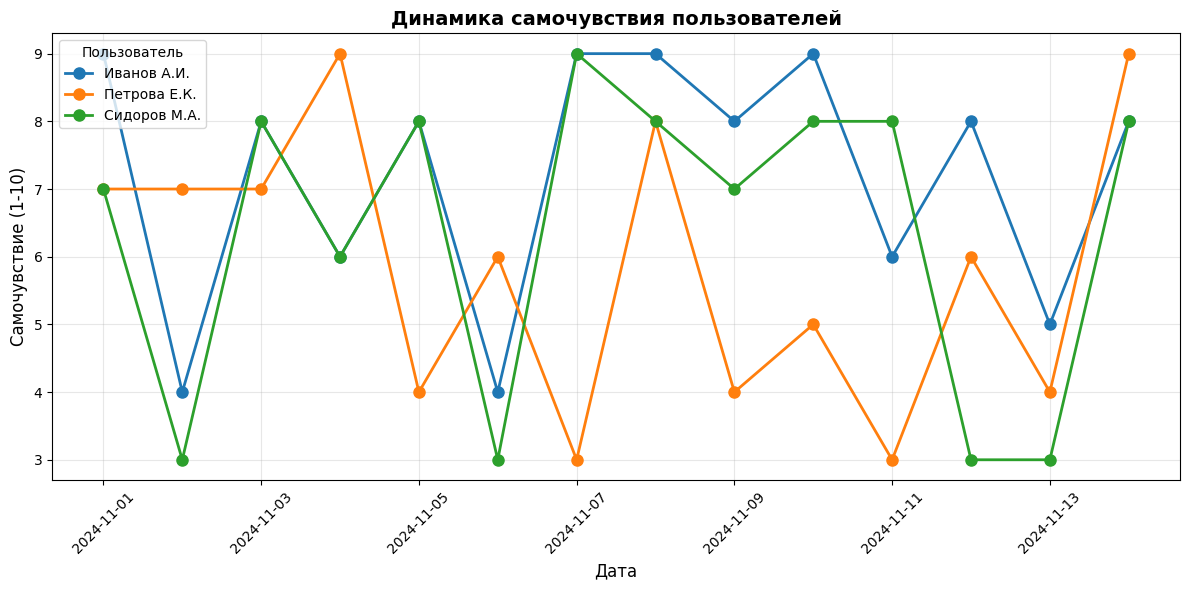

In [ ]:
import pandas as pd
import numpy as np

# Загружаем данные (пример с созданием искусственных данных для демонстрации)
np.random.seed(42)  # Для воспроизводимости результатов

# 1. ТАБЛИЦА: ЕЖЕДНЕВНЫЕ ЗАПИСИ ДНЕВНИКА
dates = pd.date_range(start='2024-11-01', periods=14, freq='D')
users = ['Иванов А.И.', 'Петрова Е.К.', 'Сидоров М.А.']

diary_data = []
for date in dates:
    for user in users:
        diary_data.append({
            'Дата': date.date(),
            'Пользователь': user,
            'Самочувствие (1-10)': np.random.randint(3, 10),
            'Головная боль (0-10)': np.random.randint(0, 7),
            'Усталость (0-10)': np.random.randint(0, 8),
            'Давление (гПа)': np.random.randint(730, 770),
            'Температура (°C)': np.random.randint(-5, 10),
            'Главный симптом': np.random.choice(['Головная боль', 'Усталость', 'Боль в суставах', 'Нет'], p=[0.3, 0.3, 0.2, 0.2])
        })

diary_df = pd.DataFrame(diary_data)

# 2. ТАБЛИЦА: СВОДНЫЙ АНАЛИЗ ЗА НЕДЕЛЮ
# Группируем данные по пользователю для анализа
summary_df = diary_df.groupby('Пользователь').agg({
    'Самочувствие (1-10)': 'mean',
    'Головная боль (0-10)': 'mean',
    'Усталость (0-10)': 'mean',
    'Давление (гПа)': ['min', 'max', 'mean'],
    'Температура (°C)': 'mean'
}).round(1)

# Упрощаем мультииндекс для красоты
summary_df.columns = ['Самочувствие_сред', 'Головная_боль_сред', 'Усталость_сред',
                      'Давление_мин', 'Давление_макс', 'Давление_сред', 'Температура_сред']
summary_df = summary_df.reset_index()

# 3. ТАБЛИЦА: ПРОГНОЗЫ И РЕКОМЕНДАЦИИ
forecast_data = [
    {'Пользователь': 'Иванов А.И.', 'Дата_прогноза': '2024-11-16', 'Прогноз_самочувствия': 6,
     'Уровень_риска': 'Средний', 'Основные_факторы_риска': 'Падение давления, высокая влажность',
     'Рекомендации': 'Отдых, избегать нагрузок'},
    {'Пользователь': 'Петрова Е.К.', 'Дата_прогноза': '2024-11-16', 'Прогноз_самочувствия': 7,
     'Уровень_риска': 'Низкий', 'Основные_факторы_риска': 'Стабильная погода',
     'Рекомендации': 'Продолжать обычный режим'},
    {'Пользователь': 'Сидоров М.А.', 'Дата_прогноза': '2024-11-16', 'Прогноз_самочувствия': 3,
     'Уровень_риска': 'Высокий', 'Основные_факторы_риска': 'Резкое похолодание, ветер',
     'Рекомендации': 'Теплая одежда, ограничить выход на улицу'}
]

forecast_df = pd.DataFrame(forecast_data)

# Функция для стилизации таблиц
def style_dataframe(df, title="", highlight_cols=None):
    """
    Красиво оформляет DataFrame для отображения в Colab[citation:1]

    Параметры:
    df - DataFrame для оформления
    title - заголовок таблицы
    highlight_cols - список столбцов для цветового выделения
    """
    styler = df.style

    # Заголовок таблицы
    if title:
        styler = styler.set_caption(f"<h3>{title}</h3>")

    # Условное форматирование для числовых столбцов[citation:1]
    # Выделение самочувствия цветом
    if 'Самочувствие' in ''.join(df.columns):
        # Ищем столбец, содержащий "Самочувствие"
        wellbeing_col = [col for col in df.columns if 'Самочувствие' in col]
        if wellbeing_col:
            styler = styler.background_gradient(subset=wellbeing_col, cmap='RdYlGn_r', vmin=1, vmax=10)

    # Выделение уровня риска цветом
    if 'Уровень_риска' in df.columns:
        risk_colors = {
            'Высокий': 'background-color: #ffcccc',
            'Средний': 'background-color: #fff2cc',
            'Низкий': 'background-color: #d9ead3'
        }

        def color_risk(val):
            return risk_colors.get(val, '')

        styler = styler.applymap(color_risk, subset=['Уровень_риска'])

    # Форматирование заголовков[citation:1]
    styler = styler.set_table_styles([
        {'selector': 'th',
         'props': [('background-color', '#4a86e8'),
                   ('color', 'white'),
                   ('font-weight', 'bold'),
                   ('text-align', 'center'),
                   ('padding', '8px')]},
        {'selector': 'td',
         'props': [('padding', '6px'),
                   ('text-align', 'center')]},
        {'selector': 'caption',
         'props': [('font-size', '16px'),
                   ('font-weight', 'bold'),
                   ('margin-bottom', '10px'),
                   ('color', '#333')]}
    ])

    # Чередование цвета строк для лучшей читаемости
    styler = styler.set_table_styles([
        {'selector': 'tbody tr:nth-child(even)',
         'props': [('background-color', '#f9f9f9')]},
        {'selector': 'tbody tr:hover',
         'props': [('background-color', '#e8f4f8')]}
    ], overwrite=False)

    return styler

# Отображаем таблицы
from IPython.display import display, HTML

print("=" * 80)
print("ТАБЛИЦА 1: ЕЖЕДНЕВНЫЙ ДНЕВНИК САМОЧУВСТВИЯ")
print("=" * 80)
display(style_dataframe(diary_df.head(10), title="Последние записи дневника"))

print("\n" + "=" * 80)
print("ТАБЛИЦА 2: СВОДНЫЙ АНАЛИЗ ПО ПОЛЬЗОВАТЕЛЯМ (ЗА 2 НЕДЕЛИ)")
print("=" * 80)
display(style_dataframe(summary_df, title="Анализ данных по пользователям"))

print("\n" + "=" * 80)
print("ТАБЛИЦА 3: ПРОГНОЗЫ И РЕКОМЕНДАЦИИ")
print("=" * 80)
display(style_dataframe(forecast_df, title="Персональные прогнозы и рекомендации"))

# Дополнительно: визуализация трендов
print("\n" + "=" * 80)
print("ДОПОЛНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ: ДИНАМИКА САМОЧУВСТВИЯ")
print("=" * 80)

# Создаём график для наглядности
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
for user in users:
    user_data = diary_df[diary_df['Пользователь'] == user]
    plt.plot(user_data['Дата'], user_data['Самочувствие (1-10)'],
             marker='o', linewidth=2, markersize=8, label=user)

plt.title('Динамика самочувствия пользователей', fontsize=14, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Самочувствие (1-10)', fontsize=12)
plt.legend(title='Пользователь')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()